# Fake News detection with tensorflow and nltk using LSTMs

In [1]:
# !rm -r /kaggle/working

rm: cannot remove '/kaggle/working': Device or resource busy


In [124]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from keras import backend as K
import joblib


plt.style.use("ggplot")

# Original LSTM+ multimodal model

## Load data with features

In [14]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip && unzip -o -d data train-checkpoint3.zip

--2023-04-22 21:06:20--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip [following]
--2023-04-22 21:06:20--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85963394 (82M) [application/zip]
Saving to: ‘train-checkpoint3.zip.2’

train-checkpoint3.z 100%[===================>]  81.98M   222MB/s    in 0.4s    

2023-04-22 21

In [153]:
df = pd.read_csv("/kaggle/working/data/train-checkpoint3.csv", index_col=False)

In [154]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [111]:
df = df.loc[:, df.columns != "text"] # Remove standalone text column

In [112]:
df = df.astype({
    "gulpease_index": np.float32,
    "smog_index": np.float32,
    "mean_word_len": np.float32,
    "real": np.float32
})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [8]:
X_train

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.099998,0.0,5.555555
14001,"['state', 'department', 'say', 'find', 'email'...",49.599998,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.500000,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.400002,14.0,6.372623
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.700001,11.1,5.973684
...,...,...,...,...
6265,"['breaking', 'hispanic', 'men', 'coward', 'bea...",53.000000,10.5,5.571429
11284,"['democratic', 'hopeful', 'sander', 'clinton',...",51.500000,13.3,6.394256
38158,"['france', 'say', 'saudi', 'coalition', 'must'...",48.500000,12.5,6.228070
860,"['palestinian', 'call', 'emergency', 'meeting'...",57.500000,13.7,6.363636


In [9]:
X_train.describe()

,gulpease_index,smog_index,mean_word_len
count,34042.000000,34042.000000,34042.000000
mean,52.411480,11.969294,6.101351
std,5.576825,3.484699,0.396024
min,-47.900002,0.000000,3.649660
25%,49.000000,11.200000,5.877928
50%,52.000000,12.500000,6.121951
75%,55.400002,13.800000,6.352941
max,115.000000,28.600000,9.333333


In [10]:
X_train.dtypes

text_norm          object
gulpease_index    float32
smog_index        float32
mean_word_len     float32
dtype: object

In [11]:
y_train.describe()

count    34042.000000
mean         0.439134
std          0.496289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: real, dtype: float64

Data looks good to create a model

## Global settings

In [61]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [62]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

## Prepare inputs

In [64]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [66]:
X_train_search = input_creator.fit_transform(X_train)
X_test_search = input_creator.transform(X_test)

### Save fitted scaler and transformer

In [68]:
import joblib
joblib.dump(input_creator.scaler, 'scaler.save')
joblib.dump(input_creator.tokenizer, 'tokenizer.save')

['tokenizer.save']

## Grid Search

In [44]:
class RNNHyperModel(kt.HyperModel):
    def build(self, hp):
        # Clear cached models
        if K.backend() == 'tensorflow':
            K.clear_session()
            
        text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
        text_features = tf.keras.layers.Embedding(
            MAX_VOCAB,
            hp.Choice("embedding", [128, 256])
        )(text_input)

        text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
        text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)
        if hp.Boolean("include_dense_text"):
            text_features = tf.keras.layers.Dense(
                hp.Choice("units_text", [32, 64], parent_name = "include_dense_text", parent_values=[True]),
                activation="relu"
            )(text_features)

        num_input = tf.keras.Input(shape=(3,), name="num_input")
        num_features = tf.keras.layers.Dense(
            hp.Choice("units_num", [8, 16]),
            activation='relu'
        )(num_input)

        merged = tf.keras.layers.concatenate([text_features, num_features])
        merged = tf.keras.layers.Dense(
            hp.Choice("units_concat", [8, 16, 32]),
            activation="relu"
        )(merged)
        merged = tf.keras.layers.Dropout(0.5)(merged)
        output = tf.keras.layers.Dense(1)(merged)

        model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

        return model

    def fit(self, hp, model, *args, test_data = None, **kwargs):
        # Convert the datasets to tf.data.Dataset.
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
        
        history = model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [30, 40, 50]),
            **kwargs
        )
        
        test_loss, test_acc = model.evaluate(*test_data)

        # Return the evaluation metric value.
        return test_loss

In [45]:
tuner = kt.RandomSearch(
    RNNHyperModel(),
    max_trials=30,
    directory="tuning",
    project_name="tune_hypermodel",
)

In [19]:
results = tuner.search(
    X_train_search, y_train, 
    test_data=(X_test_search, y_test), 
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights=True)], 
    validation_split=0.1
)

Trial 30 Complete [00h 04m 35s]
default_objective: 0.16349735856056213

Best default_objective So Far: 0.12843357026576996
Total elapsed time: 01h 04m 45s


In [20]:
tuner.results_summary(num_trials=3)

Results summary
Results in tuning/tune_hypermodel
Showing 3 best trials
Trial summary
Hyperparameters:
embedding: 256
include_dense_text: True
units_num: 8
units_concat: 32
units_text: 64
batch_size: 50
Score: 0.12843357026576996
Trial summary
Hyperparameters:
embedding: 256
include_dense_text: True
units_num: 8
units_concat: 32
units_text: 32
batch_size: 30
Score: 0.13313348591327667
Trial summary
Hyperparameters:
embedding: 128
include_dense_text: True
units_num: 16
units_concat: 8
units_text: 32
batch_size: 40
Score: 0.13652557134628296


In [36]:
theoretical_best_model = tuner.get_best_models(num_models=3)[0]
theoretical_best_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
theoretical_best_model.evaluate(X_test_search, y_test)

266/266 [==============================] - 6s 15ms/step - loss: 0.1284 - accuracy: 0.9537


[0.12843357026576996, 0.9537069797515869]

In [26]:
results = []
for i, params in enumerate(tuner.get_best_hyperparameters(num_trials=3)):
    param_dict = {
        "embedding": params.get("embedding"),
        "include_dense_text": params.get("include_dense_text"),
        "units_text": params.get("units_text"),
        "units_num": params.get("units_num"),
        "units_concat": params.get("units_concat"),
        "batch_size": params.get("batch_size")
    }
    results.append({
        "name": f"model{i}",
        "params": param_dict
    })

In [13]:
results

[{'name': 'model0',
  'params': {'embedding': 256,
   'include_dense_text': True,
   'units_text': 64,
   'units_num': 8,
   'units_concat': 32,
   'batch_size': 50}},
 {'name': 'model1',
  'params': {'embedding': 256,
   'include_dense_text': True,
   'units_text': 32,
   'units_num': 8,
   'units_concat': 32,
   'batch_size': 30}},
 {'name': 'model2',
  'params': {'embedding': 128,
   'include_dense_text': True,
   'units_text': 32,
   'units_num': 16,
   'units_concat': 8,
   'batch_size': 40}}]

In [30]:
results_processed = []
for record in results:
    name = record["name"]
    params = record["params"]
    results_processed.append((name, *params.values()))
results_processed = pd.DataFrame(results_processed)
results_processed.columns = ("name", "embedding", "include_dense_text", "dense_units_text", "dense_units_num", "dense_units_concat", "batch_size")

In [31]:
results_processed

,name,embedding,include_dense_text,dense_units_text,dense_units_num,dense_units_concat,batch_size
0,model0,256,True,64,8,32,50
1,model1,256,True,32,8,32,30
2,model2,128,True,32,16,8,40


In [32]:
results_processed.to_csv("models-for-cv.csv")

## Models crossvalidation

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [27]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [28]:
def create_model(embedding, include_dense_text, units_text, units_num, units_concat):
    # Clear cached models
    if K.backend() == 'tensorflow':
        K.clear_session()
    
    text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
    text_features = tf.keras.layers.Embedding(MAX_VOCAB, embedding)(text_input)

    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)
    if include_dense_text:
        text_features = tf.keras.layers.Dense(
            units_text,
            activation="relu"
        )(text_features)

    num_input = tf.keras.Input(shape=(3,), name="num_input")
    num_features = tf.keras.layers.Dense(
        units_num,
        activation='relu'
    )(num_input)

    merged = tf.keras.layers.concatenate([text_features, num_features])
    merged = tf.keras.layers.Dense(
        units_concat,
        activation="relu"
    )(merged)
    merged = tf.keras.layers.Dropout(0.5)(merged)
    output = tf.keras.layers.Dense(1)(merged)

    model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    return model

In [29]:
cv_results = {
    "model0": [],
    "model1": [],
    "model2": []
}

In [30]:
cv_results = np.load('cv_results.npy',allow_pickle='TRUE').item()

FileNotFoundError: [Errno 2] No such file or directory: 'cv_results.npy'

In [33]:
np.save("cv_results.npy", cv_results)

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(df)):
    input_creator = ModelInputCreator(
        max_vocab = MAX_VOCAB,
        max_len = MAX_LEN,
        texts_column = "text_norm",
        numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
    )
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print("  Preprocessing data ...")
    X_fold_train = input_creator.fit_transform(df.loc[:, df.columns != "real"].iloc[train_index])
    X_fold_test = input_creator.transform(df.loc[:, df.columns != "real"].iloc[test_index])
    y_fold_train =  df["real"].iloc[train_index]
    y_fold_test =  df["real"].iloc[test_index]

    print("  Evaluating model:")
    for records in results:
        name = records["name"]
        params = records["params"]
        print(f"    Training model {name}")
        
        model = create_model(params["embedding"], params["include_dense_text"], params["units_text"], params["units_num"], params["units_concat"])
        model.fit(X_fold_train, y_fold_train, epochs=10, validation_split=0.1, batch_size=params["batch_size"], callbacks=[early_stop])
        
        print(f"    Evaluating model {name}")
        eval_loss, eval_acc = model.evaluate(X_fold_test, y_fold_test)
        y_fold_pred = model.predict(X_fold_test)
        auc_score = roc_auc_score(y_fold_test, y_fold_pred)
        
        cv_results[name].append((eval_loss, eval_acc, auc_score))
        np.save("cv_results.npy", cv_results) # auto_save


Fold 0:
  Train: index=[    0     1     2 ... 42550 42551 42552]
  Test:  index=[    6    18    22 ... 42525 42531 42543]
  Preprocessing data ...
  Evaluating model:
    Training model model0
Epoch 1/10
613/613 [==============================] - 110s 157ms/step - loss: 0.3713 - accuracy: 0.8090 - val_loss: 0.1997 - val_accuracy: 0.9216
Epoch 2/10
613/613 [==============================] - 46s 76ms/step - loss: 0.1264 - accuracy: 0.9594 - val_loss: 0.1506 - val_accuracy: 0.9436
Epoch 3/10
613/613 [==============================] - 35s 58ms/step - loss: 0.0714 - accuracy: 0.9794 - val_loss: 0.1696 - val_accuracy: 0.9445
Epoch 4/10
613/613 [==============================] - 30s 48ms/step - loss: 0.0422 - accuracy: 0.9883 - val_loss: 0.1874 - val_accuracy: 0.9480
    Evaluating model model0
266/266 [==============================] - 5s 13ms/step
    Training model model1
Epoch 1/10
1022/1022 [==============================] - 135s 124ms/step - loss: 0.3662 - accuracy: 0.8250 - val_loss: 0

In [32]:
cv_results

{'model0': [(0.14145825803279877, 0.9488896727561951, 0.9879647350682113),
  (0.1369277536869049, 0.9472447633743286, 0.9888570279348441),
  (0.1342208832502365, 0.9483022093772888, 0.9887383689215626),
  (0.1397317498922348, 0.9515863656997681, 0.9898951618354255),
  (0.1360967606306076, 0.9515863656997681, 0.9894594661317107)],
 'model1': [(0.13332867622375488, 0.9514745473861694, 0.9890636550662304),
  (0.14085333049297333, 0.9501821398735046, 0.9878076935275579),
  (0.14055407047271729, 0.9487721920013428, 0.9871642997764126),
  (0.16035068035125732, 0.9443008303642273, 0.9847470889229787),
  (0.145039364695549, 0.9485311508178711, 0.9871337397014049)],
 'model2': [(0.17074371874332428, 0.9478322267532349, 0.9877338198574532),
  (0.1383667141199112, 0.9491246342658997, 0.9877963181732546),
  (0.13156309723854065, 0.9542944431304932, 0.9899655272498586),
  (0.16281791031360626, 0.9400705099105835, 0.9837836122914977),
  (0.15714168548583984, 0.9471210241317749, 0.9876008588491507)]}

In [35]:
parsered_cv_results = []
for key, values in cv_results.items():
    for test_loss, test_acc, roc_auc in values:
        gini = 2 * roc_auc - 1
        parsered_cv_results.append((key, test_loss, test_acc, roc_auc, gini))
df_cv_results = pd.DataFrame(parsered_cv_results)
df_cv_results.columns = ("name", "loss", "accuracy", "roc_auc", "gini")

In [36]:
df_cv_results

,name,loss,accuracy,roc_auc,gini
0,model0,0.141458,0.948890,0.987965,0.975929
1,model0,0.136928,0.947245,0.988857,0.977714
2,model0,0.134221,0.948302,0.988738,0.977477
3,model0,0.139732,0.951586,0.989895,0.979790
4,model0,0.136097,0.951586,0.989459,0.978919
5,model1,0.133329,0.951475,0.989064,0.978127
6,model1,0.140853,0.950182,0.987808,0.975615
7,model1,0.140554,0.948772,0.987164,0.974329
8,model1,0.160351,0.944301,0.984747,0.969494
9,model1,0.145039,0.948531,0.987134,0.974267


In [37]:
df_cv_results.to_csv("cross-validation-results.csv")

Text(0.5, 1.0, 'Loss distribution in test per model')

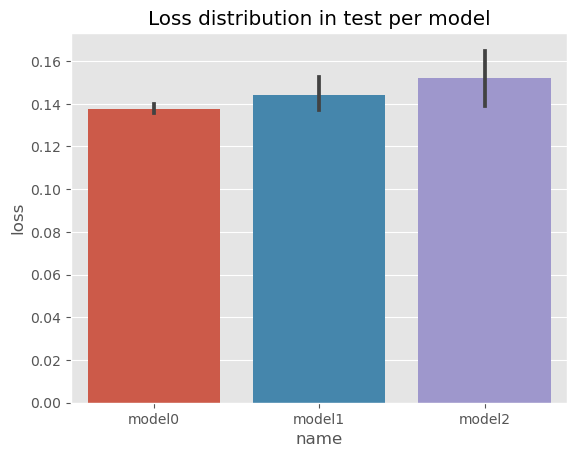

In [38]:
sns.barplot(df_cv_results, x = "name", y = "loss")
plt.title("Loss distribution in test per model")

(0.9, 1.0)

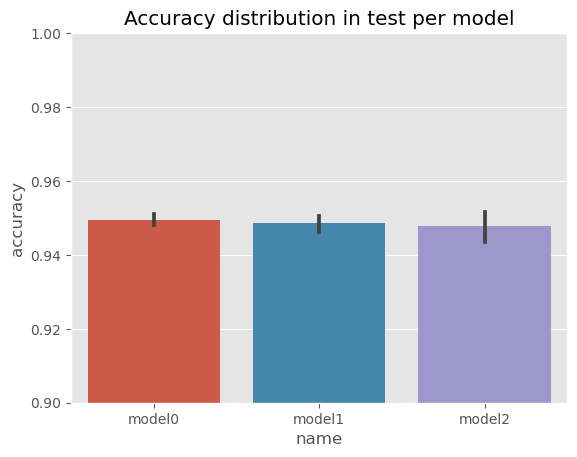

In [39]:
sns.barplot(df_cv_results, x = "name", y = "accuracy")
plt.title("Accuracy distribution in test per model")
plt.ylim((0.90,1))

(0.9, 1.0)

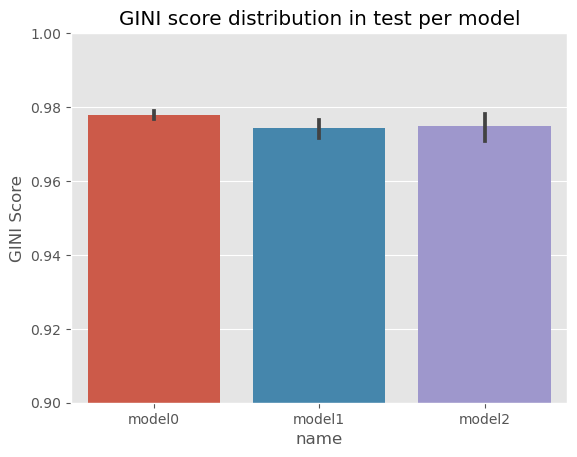

In [41]:
sns.barplot(df_cv_results, x = "name", y = "gini")
plt.ylabel("GINI Score")
plt.title("GINI score distribution in test per model")
plt.ylim((0.90,1))

## Final model

In [46]:
best_model = tuner.get_best_models(num_models=3)[0] # model0
best_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [48]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)
X_train_transformed = input_creator.fit_transform(X_train)
X_test_transformed = input_creator.transform(X_test)

In [49]:
best_model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 7s 15ms/step - loss: 0.1284 - accuracy: 0.9537


[0.12843357026576996, 0.9537069797515869]

In [50]:
y_pred = best_model.predict(X_test_transformed)

266/266 [==============================] - 5s 14ms/step


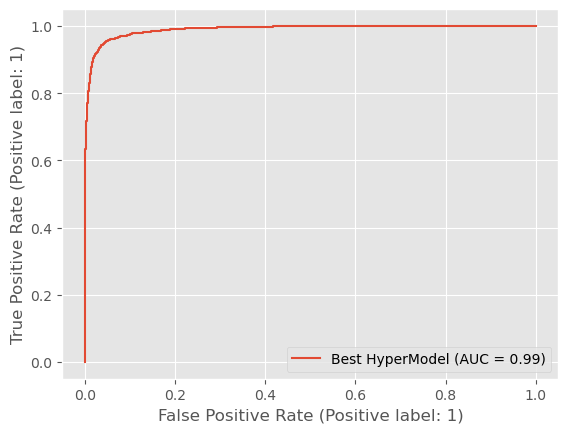

In [52]:
RocCurveDisplay.from_predictions(y_test, y_pred, name="Best HyperModel")

In [149]:
roc05 = (y_pred > 0.5) * 1

In [150]:
cm = confusion_matrix(y_test, roc05) / np.sum(confusion_matrix(y_test, roc05))

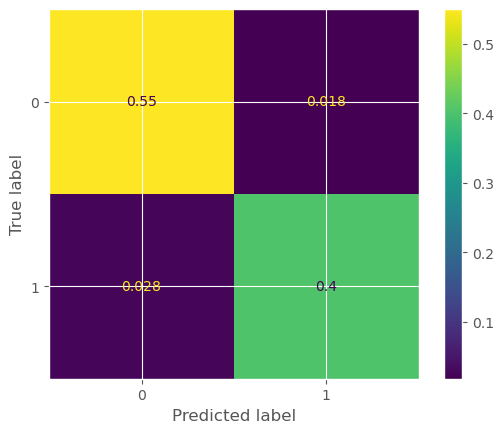

In [151]:
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [89]:
best_model.save('best_model.h5')

In [90]:
best_model.save_weights('best_model_weights.h5')

In [75]:
loaded_model = tf.keras.models.load_model("best_model.h5")

In [87]:
!python3 --version

Python 3.7.12
